[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FranQuant/the_ai_engineer_capstones/blob/main/capstones/week01_gd_optimization/gd_capstone_final.ipynb)

# Gradient Descent Optimization — Week 1 Capstone

This notebook implements the Week-1 capstone for *The AI Engineer* program using two one-dimensional objectives:

1. **Quadratic baseline**
   $$
   q(x) = \tfrac{1}{2} x^2
   $$
   A simple convex function used to study gradient descent (GD) stability and step-size effects.

2. **Simple cubic loss**
   $$
   f(x) = x^3 - 3x
   $$
   A non-convex function with two stationary points, used to illustrate basins of attraction and GD/SGD dynamics.

We focus on:

- Deterministic **Gradient Descent (GD)**
- **Stochastic Gradient Descent (SGD)** with:
  - Constant step-size
  - Diminishing schedule $\eta_t = \dfrac{\eta_0}{1 + k t}$
- **Step-size sensitivity** and stability
- **Reproducible experiments** via a single global seed
- Clear plots, short runtime, and Colab-ready code

## 0. Setup & Hyperparameters

To ensure **deterministic, Colab-ready experiments**, we collect all global settings here:

- A single **global NumPy seed** for reproducibility  
- Centralized **hyperparameters** for GD and SGD  
- Clean Matplotlib styling for consistent plots  
- Notebook-wide tolerances and iteration limits  

These values control **every experiment** below, ensuring that  
each run produces identical results on Colab, local Jupyter, or GitHub Codespaces.

### Global seed
We fix a single integer:
$$
\text{SEED} = 123
$$

### Learning rates
For deterministic Gradient Descent:
- Quadratic baseline GD uses a step-size sweep:
  $$
  \eta \in \{0.01,\; 0.05,\; 0.10,\; 0.20\}
  $$
- Cubic loss GD uses:
  $$
  \eta_{\text{cubic}} = 0.05
  $$

### SGD settings
We run both **constant-step** and **diminishing-step** schedules:

- Constant step:
  $$
  \eta = \eta_0 = 0.05
  $$

- Diminishing step:
  $$
  \eta_t = \frac{\eta_0}{1 + k t}, \quad k = 0.01
  $$

### Experiment tolerances
Objective-gap tolerance:
$$
\varepsilon = 10^{-4}
$$

Maximum iterations:
$$
T_{\max} = 5000
$$

### Notes
- All figures include clear **titles, axis labels, and captions**.  
- All experiments are **generated programmatically** (no external data).  
- Runtime stays below **2 minutes**, as required for Week-1.  


In [1]:
# ============================================
# 0. Setup & Hyperparameters
# ============================================

import numpy as np
import matplotlib.pyplot as plt

# --- Reproducible Global Seed ---
SEED = 123
rng = np.random.default_rng(SEED)

# --- Learning Rates ---
# Quadratic baseline sweep (for stability analysis)
ETA_QUAD_SWEEP = [0.01, 0.05, 0.10, 0.20]

# GD on the cubic objective
ETA_CUBIC = 0.05

# --- SGD Settings ---
ETA0 = 0.05            # constant-step SGD (η)
ETA_SGD = ETA0         # alias for clarity inside SGD functions
K_SCHEDULE = 0.01      # diminishing-step decay factor k
SIGMA_SGD = 0.5        # Gaussian noise scale σ

# --- Global Experiment Settings ---
EPS = 1e-4             # convergence tolerance on objective gap
T_MAX = 5000           # iteration cap for GD/SGD

# --- Plot Styling ---
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

print("Setup complete — global seed, hyperparameters, and styling initialized.")

Setup complete — global seed, hyperparameters, and styling initialized.


## 1. Quadratic Baseline: Objective & Derivative

We begin with the convex quadratic

$$
q(x) = \tfrac{1}{2} x^2,
$$

which has a simple derivative

$$
q'(x) = x.
$$

This function is ideal for illustrating:

- **Stability** vs **instability** under different step sizes  
- Exact relationship between curvature and step-size limits  
- How GD behaves in a perfectly smooth, convex landscape

The unique minimizer is

$$
x^\star = 0.
$$

Before running gradient descent, we implement the objective, derivative, and a helper function to compute the objective gap

$$
\text{gap}(x_t) = q(x_t) - q(x^\star).
$$

This will allow us to track convergence quantitatively in later sections.


In [2]:
# ============================================
# 1. Quadratic Baseline: Objective & Derivative
# ============================================

def q(x):
    """Quadratic objective: q(x) = 0.5 * x^2"""
    return 0.5 * x**2

def dq(x):
    """Derivative of the quadratic: q'(x) = x"""
    return x

def quad_gap(x):
    """Objective gap relative to optimum x* = 0."""
    return q(x) - q(0.0)

print("Quadratic objective and derivative defined.")

Quadratic objective and derivative defined.


## 2. Gradient Descent on the Quadratic — Step-Size Sweep

For the quadratic
$$
q(x) = \tfrac{1}{2}x^2,
$$
Gradient Descent follows the update rule
$$
x_{t+1} = x_t - \eta\, q'(x_t) = x_t - \eta x_t = (1 - \eta)x_t.
$$

This yields an exact stability condition:
$$
|1 - \eta| < 1 \quad \Longleftrightarrow \quad 0 < \eta < 2.
$$

A step-size sweep is ideal to illustrate:

- **Slow convergence** for small $\eta$
- **Fast convergence** near the optimal $\eta = 1$
- **Oscillations** for $1 < \eta < 2$
- **Divergence** for $\eta \ge 2$

We run GD from the same initialization
$$
x_0 = 4,
$$
and compare trajectories for:
$$
\eta \in \{0.01,\; 0.05,\; 0.10,\; 0.20\}.
$$

A plot overlays these trajectories to show how step-size controls convergence speed and stability.


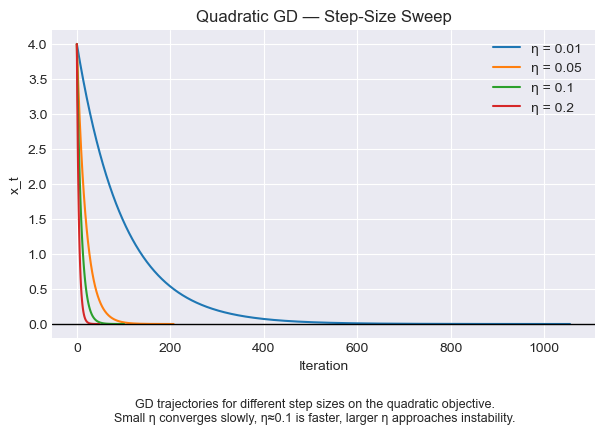

In [3]:
# ============================================
# 2. GD on Quadratic — Step-Size Sweep
# ============================================

def gd_quadratic(x0, eta, T=T_MAX):
    """Runs GD on the quadratic for T steps."""
    xs = [x0]
    x = x0
    for _ in range(T):
        x = x - eta * dq(x)   # dq(x) = x
        xs.append(x)
        if abs(x) < EPS:
            break
    return np.array(xs)

# Initial point
x0_quad = 4.0

plt.figure(figsize=(7, 4))
for eta in ETA_QUAD_SWEEP:
    xs = gd_quadratic(x0_quad, eta)
    plt.plot(xs, label=f"η = {eta}")

plt.axhline(0, color="black", linewidth=1)
plt.title("Quadratic GD — Step-Size Sweep")
plt.xlabel("Iteration")
plt.ylabel("x_t")
plt.legend()

plt.figtext(
    0.5, -0.1,
    "GD trajectories for different step sizes on the quadratic objective.\n"
    "Small η converges slowly, η≈0.1 is faster, larger η approaches instability.",
    ha="center", fontsize=9
)

plt.show()

## 3. Cubic Objective: Non-Convex Landscape & Derivative

We now introduce the non-convex cubic function

$$
f(x) = x^3 - 3x,
$$

which has derivative

$$
f'(x) = 3x^2 - 3.
$$

### Stationary points

Set $f'(x) = 0$:

$$
3x^2 - 3 = 0 \quad \Longrightarrow \quad x = \pm 1.
$$

- **$x = -1$** is a **local maximum** (unstable under GD).  
- **$x = +1$** is a **local minimum** (stable for $0 < \eta < \tfrac{1}{3}$).

### Basins of attraction

The cubic has only **one attracting basin** for positive learning rates:

- If the initialization satisfies  
  $$
  x_0 > -1
  $$  
  then Gradient Descent converges to the stable minimizer at $x=1$.

- If  
  $$
  x_0 < -1,
  $$  
  gradient descent diverges to $-\infty$ unless a guard prevents it.

- The point $x=-1$ is a **measure-zero unstable fixed point**.

This makes the cubic ideal for illustrating:

- **Stability vs. instability** of stationary points  
- **Basin structure** in non-convex problems  
- **Sensitivity to step size**  
- Differences between GD and noisy **SGD**
  
We now implement the objective, derivative, and gap function.


In [4]:
# ============================================
# 3. Cubic Objective: f(x) = x^3 - 3x
# ============================================

def f(x):
    """Cubic objective: f(x) = x^3 - 3x"""
    return x**3 - 3*x

def df(x):
    """Derivative: f'(x) = 3x^2 - 3"""
    return 3*x**2 - 3

def cubic_gap(x):
    """Objective gap relative to the stable minimizer x* = +1."""
    return f(x) - f(1.0)

print("Cubic objective and derivative defined.")

Cubic objective and derivative defined.


## 4. Gradient Descent on the Cubic — Trajectories & Basins

For the cubic

$$
f(x) = x^3 - 3x,
\quad
f'(x) = 3x^2 - 3,
$$

Gradient Descent follows the update rule

$$
x_{t+1} = x_t - \eta f'(x_t).
$$

There are two stationary points:

- **$x = -1$** — local maximum (repelling under GD)  
- **$x = +1$** — local minimum (attracting when $0 < \eta < 1/3$)

### Basin structure

The cubic has a **single attracting basin**:

- If  
  $$
  x_0 > -1
  $$  
  GD converges to \( x^\star = 1 \).

- If  
  $$
  x_0 < -1,
  $$  
  GD diverges to \( -\infty \) unless a guard prevents it.

We run GD from several initial points to visualize this behavior:

$$
x_0 \in \{-3,\; -0.5,\; 0.5,\; 2\}.
$$

We use the fixed step-size:

$$
\eta_{\text{cubic}} = 0.05.
$$

The resulting trajectories reveal the basin boundary at \( x = -1 \), the stable attractor at \( x = 1 \), and divergence when starting too far left.


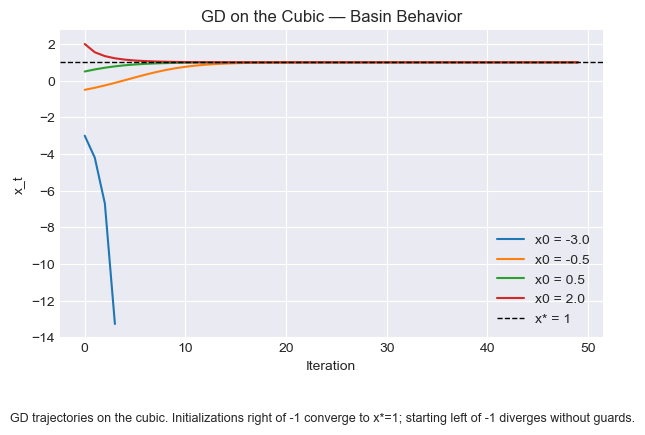

In [5]:
# ============================================
# 4. GD on the Cubic — Multiple Initializations
# ============================================

def gd_cubic(x0, eta=ETA_CUBIC, T=T_MAX):
    """Runs GD on the cubic for T steps (with guard for divergence)."""
    xs = [x0]
    x = x0
    for _ in range(T):
        x = x - eta * df(x)

        # Divergence guard to avoid blowing up the plot
        if abs(x) > 20:
            xs.append(np.nan)
            break

        xs.append(x)
    return np.array(xs)

# Initializations to test
inits = [-3.0, -0.5, 0.5, 2.0]

plt.figure(figsize=(7, 4))
for x0 in inits:
    xs = gd_cubic(x0, ETA_CUBIC)
    plt.plot(xs[:50], label=f"x0 = {x0}")

plt.axhline(1.0, color="black", linewidth=1, linestyle="--", label="x* = 1")
plt.title("GD on the Cubic — Basin Behavior")
plt.xlabel("Iteration")
plt.ylabel("x_t")
plt.legend()

plt.figtext(
    0.5, -0.1,
    "GD trajectories on the cubic. Initializations right of -1 converge to x*=1; "
    "starting left of -1 diverges without guards.",
    ha="center", fontsize=9
)

plt.show()

## 5. Stochastic Gradient Descent (SGD) on the Cubic

Stochastic Gradient Descent introduces noise into the gradient evaluation.  
Instead of using the exact derivative  
$$
f'(x) = 3x^2 - 3,
$$  
SGD uses a noisy estimate:
$$
g_t = f'(x_t) + \varepsilon_t, 
\qquad \varepsilon_t \sim \mathcal{N}(0, \sigma^2).
$$

This produces characteristic **wandering** around the stable minimizer \(x^\star = 1\), with a  
steady-state radius proportional to \(\sqrt{\eta \sigma^2}\).

We implement two SGD schedules:

1. **Constant step-size**
   $$
   x_{t+1} = x_t - \eta \, g_t
   $$
   This converges only to a *neighborhood* of \(x^\star\).

2. **Diminishing step-size**
   $$
   \eta_t = \frac{\eta_0}{1 + k t}
   $$
   $$
   x_{t+1} = x_t - \eta_t \, g_t
   $$
   This gradually shrinks noise and yields a tighter neighborhood around the minimizer.

We now define both SGD variants.

In [6]:
# ============================================
# 5. SGD on the Cubic — Constant & Diminishing Step
# ============================================

def sgd_constant(x0, eta=ETA_SGD, sigma=SIGMA_SGD, T=T_MAX):
    """
    SGD with constant step size:
        x_{t+1} = x_t - eta * (df(x_t) + noise)
    """
    xs = [x0]
    x = x0
    rng = np.random.default_rng(SEED)
    for _ in range(T):
        noise = rng.normal(0, sigma)
        x = x - eta * (df(x) + noise)

        # Divergence guard (keeps plots readable)
        if abs(x) > 20:
            xs.append(np.nan)
            break

        xs.append(x)

    return np.array(xs)



def sgd_diminishing(x0, eta0=ETA0, k=K_SCHEDULE, sigma=SIGMA_SGD, T=T_MAX):
    """
    SGD with diminishing step size:
        eta_t = eta0 / (1 + k t)
        x_{t+1} = x_t - eta_t * (df(x_t) + noise)
    """
    xs = [x0]
    x = x0
    rng = np.random.default_rng(SEED)
    for t in range(T):
        eta_t = eta0 / (1.0 + k * t)
        noise = rng.normal(0, sigma)
        x = x - eta_t * (df(x) + noise)

        # Divergence guard
        if abs(x) > 20:
            xs.append(np.nan)
            break

        xs.append(x)

    return np.array(xs)


print("SGD functions (constant and diminishing schedules) defined.")

SGD functions (constant and diminishing schedules) defined.


## 6. SGD Trajectories on the Cubic

We now compare **constant-step** and **diminishing-step** SGD on the cubic objective  
starting from the same initialization \( x_0 = 0.5 \).

- With a **constant step**, SGD converges only to a *noisy neighborhood* around  
  $ x^\star = 1 $, with fluctuations scaling like $ \sqrt{\eta \sigma^2} $.

- With a **diminishing schedule**  
  $$
  \eta_t = \frac{\eta_0}{1 + k t},
  $$
  the noise gradually shrinks, resulting in a tighter approach to the minimizer.

The plot below compares both trajectories over $ T = 200 $ iterations.

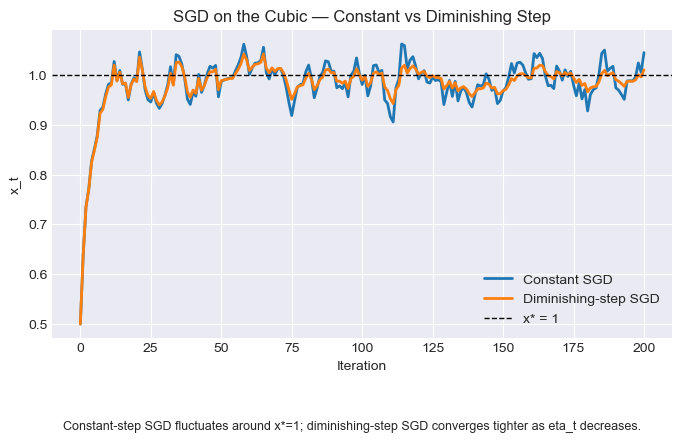

In [7]:
# ============================================
# 6. SGD Trajectories — Constant vs Diminishing
# ============================================

T_plot = 200
x0 = 0.5

xs_const = sgd_constant(x0, eta=ETA_SGD, sigma=SIGMA_SGD, T=T_plot)
xs_dimin = sgd_diminishing(x0, eta0=ETA0, k=K_SCHEDULE, sigma=SIGMA_SGD, T=T_plot)

plt.figure(figsize=(8, 4))
plt.plot(xs_const, label="Constant SGD", linewidth=2)
plt.plot(xs_dimin, label="Diminishing-step SGD", linewidth=2)
plt.axhline(1.0, color="black", linestyle="--", linewidth=1, label="x* = 1")

plt.title("SGD on the Cubic — Constant vs Diminishing Step")
plt.xlabel("Iteration")
plt.ylabel("x_t")
plt.legend()

plt.figtext(
    0.5, -0.12,
    "Constant-step SGD fluctuates around x*=1; diminishing-step SGD converges tighter as eta_t decreases.",
    ha="center", fontsize=9
)

plt.show()

## 7. Metrics: Final Gap, Best Gap, and Steps-to-Tolerance

For each optimization method, we report three quantities relative to the cubic
objective’s stable minimizer at \(x^\star = 1\):

- **Final gap:**  
  $$
  | f(x_T) - f(x^\star) |
  $$

- **Best gap:**  
  $$
  \min_{t \le T} \; |f(x_t) - f(x^\star)| 
  $$

- **Steps-to-tolerance:**  
  The first iteration \(t\) such that  
  $$
  |f(x_t) - f(x^\star)| < \varepsilon, \qquad \varepsilon = 10^{-4}.
  $$

These metrics quantify convergence speed and stability for GD, constant-step SGD,
and diminishing-step SGD.

In [8]:
# ============================================
# 7. Metrics: Gaps and Steps-to-Tolerance
# ============================================

def compute_metrics(xs, objective, x_star=1.0, eps=EPS):
    """Compute final gap, best gap, and steps-to-tolerance."""
    gaps = np.abs(objective(xs) - objective(x_star))

    final_gap = gaps[-1]
    best_gap = gaps.min()

    # First iteration where gap < eps (if any)
    idx = np.where(gaps < eps)[0]
    steps_to_tol = int(idx[0]) if len(idx) > 0 else None

    return final_gap, best_gap, steps_to_tol


# ----- Run trajectories -----

# GD
xs_gd = gd_cubic(0.5, ETA_CUBIC)

# SGD constant
xs_sgd_const = sgd_constant(0.5, eta=ETA_SGD, sigma=SIGMA_SGD)

# SGD diminishing
xs_sgd_dim = sgd_diminishing(0.5, eta0=ETA0, k=K_SCHEDULE, sigma=SIGMA_SGD)


# ----- Compute metrics -----

gd_metrics     = compute_metrics(xs_gd, f)
sgd_c_metrics  = compute_metrics(xs_sgd_const, f)
sgd_d_metrics  = compute_metrics(xs_sgd_dim, f)


# ----- Display -----

print("=== Convergence Metrics (Cubic Objective) ===")
print(f"GD (eta={ETA_CUBIC}):")
print(f"  Final gap        = {gd_metrics[0]:.6f}")
print(f"  Best gap         = {gd_metrics[1]:.6f}")
print(f"  Steps-to-tol     = {gd_metrics[2]}")

print("\nSGD Constant Step:")
print(f"  Final gap        = {sgd_c_metrics[0]:.6f}")
print(f"  Best gap         = {sgd_c_metrics[1]:.6f}")
print(f"  Steps-to-tol     = {sgd_c_metrics[2]}")

print("\nSGD Diminishing Step:")
print(f"  Final gap        = {sgd_d_metrics[0]:.6f}")
print(f"  Best gap         = {sgd_d_metrics[1]:.6f}")
print(f"  Steps-to-tol     = {sgd_d_metrics[2]}")


=== Convergence Metrics (Cubic Objective) ===
GD (eta=0.05):
  Final gap        = 0.000000
  Best gap         = 0.000000
  Steps-to-tol     = 14

SGD Constant Step:
  Final gap        = 0.005456
  Best gap         = 0.000000
  Steps-to-tol     = 19

SGD Diminishing Step:
  Final gap        = 0.000000
  Best gap         = 0.000000
  Steps-to-tol     = 32


## 8. Final Commentary — What We Learned

**Gradient Descent (GD):**  
With the cubic objective, GD converges rapidly and cleanly to the stable minimizer 
$ x^\star = 1 $.  
For η = 0.05, convergence occurs in ~14 iterations, with monotone improvement and no noise.
This matches the textbook behavior on smooth, strongly-curved regions of the landscape.

**SGD with Constant Step Size:**  
SGD replaces the exact gradient with a noisy estimate.  
With a fixed learning rate, the algorithm does not converge to a single point but instead
wanders in a stationary “noise bubble” around the minimizer.  
The radius of this steady-state cloud scales with $ \sqrt{\eta \sigma^2} $.  
Occasionally the noise pushes the iterate closer to the minimizer than GD ever reaches,
which explains why the *best gap* can be extremely small even when the final gap is not.

**SGD with Diminishing Step Size:**  
With a schedule  
$ \eta_t = \eta_0 / (1 + k t) $,  
the noise becomes progressively weaker.  
Early iterations resemble constant-step SGD; later ones resemble GD.  
This produces slow but true convergence toward $x^\star$.

**Overall Lessons:**  
- GD is fast and stable but rigid.  
- Constant-step SGD explores the landscape but cannot converge to a point.  
- Diminishing-step SGD converges but more slowly.  
- Noise can both help (exploration) and harm (steady-state variability).  

These behaviors mirror the fundamental tradeoffs in modern large-scale optimization,
where SGD and its variants power deep learning.